In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import os


In [4]:

# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [5]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
print(df_encoded.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0            0             0                        0   
1         0            0             0                        0   
2         0            1             0                        0   
3         0            0             0                        1   
4         0            1             0                        1   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0             

In [6]:
testDF = df_encoded

In [7]:
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [8]:
# Filename for the autoencoder model
model_file = './models/autoencoder_trial2.keras'

# Function to create the encoder model, required for KerasRegressor
def create_encoder(input_dim, encoding_dim=13, learning_rate=0.00005, dropout_rate=0.3):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256)(input_layer)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(64)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(encoding_dim, activation='linear')(encoded)  # Bottleneck layer

    encoder = Model(input_layer, encoded)
    encoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return encoder

# Function to create the decoder model
def create_decoder(encoding_dim, input_dim, learning_rate=0.00005):
    encoded_input = Input(shape=(encoding_dim,))
    decoded = Dense(64)(encoded_input)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(128)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(256)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    decoder = Model(encoded_input, decoded)
    decoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return decoder

# Check if the model file exists, load it if available, otherwise train a new model
if os.path.exists(model_file):
    print("Model file exists. Loading the model...")
    autoencoder = load_model(model_file)
else:
    print("Model file does not exist. Training a new model...")

    # Define input dimensions
    input_dim = x_train.shape[1]  # Assuming 13 features

    # Wrap the encoder model using KerasRegressor
    encoder_model = KerasRegressor(build_fn=create_encoder, input_dim=input_dim, verbose=0, dropout_rate=0.2, encoding_dim=8, learning_rate=0.0001)

    # Define the hyperparameter grid for the encoder
    param_grid = {
        'encoding_dim': [8, 13, 16],
        'learning_rate': [0.0001, 0.00005],
        'dropout_rate': [0.2, 0.3, 0.4],
        'epochs': [100, 200],
        'batch_size': [32, 64]
    }

    # Perform grid search with cross-validation for the encoder
    grid = GridSearchCV(estimator=encoder_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_result = grid.fit(x_train, x_train)

    # Print the best parameters and score for the encoder
    print(f"Best parameters for encoder: {grid_result.best_params_}")
    print(f"Best score for encoder: {grid_result.best_score_}")

    # Train the final encoder model with the best parameters
    best_params = grid_result.best_params_
    encoder = create_encoder(input_dim, **best_params)
    history_encoder = encoder.fit(x_train, x_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                                  validation_split=0.2, verbose=1,
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Train the Decoder separately
    encoded_train = encoder.predict(x_train)
    decoder = create_decoder(best_params['encoding_dim'], input_dim, best_params['learning_rate'])
    history_decoder = decoder.fit(encoded_train, x_train, epochs=200, validation_split=0.2, verbose=1,
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Combine Encoder and Decoder to form the Autoencoder
    autoencoder_input = Input(shape=(input_dim,))
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)
    autoencoder = Model(autoencoder_input, reconstructed)
    autoencoder.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')

    # Save the model as autoencoder.keras
    autoencoder.save(model_file)
    print("Model trained and saved.")
    
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history_encoder.history['loss'], label='Encoder Training Loss')
    plt.plot(history_encoder.history['val_loss'], label='Encoder Validation Loss')
    plt.plot(history_decoder.history['loss'], label='Decoder Training Loss')
    plt.plot(history_decoder.history['val_loss'], label='Decoder Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Calculate reconstruction error on the test set
reconstructed_test = autoencoder.predict(x_test)
reconstruction_error = np.mean(np.square(x_test - reconstructed_test), axis=1)

# Convert reconstruction error to percentage
reconstruction_error_percentage = np.mean(reconstruction_error) * 100

# Print reconstruction error percentage
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')

Model file does not exist. Training a new model...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


d:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Anaconda\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "d:\Anaconda\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "d:\Anaconda\lib\site-packages\scikeras\wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_a

Best parameters for encoder: {'batch_size': 64, 'dropout_rate': 0.4, 'encoding_dim': 13, 'epochs': 100, 'learning_rate': 5e-05}
Best score for encoder: 0.7976351889490528


TypeError: create_encoder() got an unexpected keyword argument 'batch_size'

In [43]:
age_groups = [(0, 29), (30, 59), (60, 89)]

datasets = {}
for start, end in age_groups:
    group_name = f"{start}-{end}"
    datasets[group_name] = df_encoded[(df_encoded['age'] >= start) & (df_encoded['age'] <= end)]

# Display the number of records in each dataset
for group_name, dataset in datasets.items():
    print(f"Age group {group_name}: {len(dataset)} records")

Age group 0-29: 32435 records
Age group 30-59: 42510 records
Age group 60-89: 25055 records


In [44]:
# Load the autoencoder model
model_file = './models/autoencoder.keras'
autoencoder = load_model(model_file)
print("Model loaded successfully.")


# Create test data for other age ranges
testDF_0_29 = datasets['0-29']
testDF_30_59 = datasets['30-59']
testDF_60_89 = datasets['60-89']

# Prepare the test data
x_test_0_29 = testDF_0_29.drop(['diabetes'], axis=1)
y_test_0_29 = testDF_0_29['diabetes']

x_test_30_59 = testDF_30_59.drop(['diabetes'], axis=1)
y_test_30_59 = testDF_30_59['diabetes']

x_test_60_89 = testDF_60_89.drop(['diabetes'], axis=1)
y_test_60_89 = testDF_60_89['diabetes']

print("Test data for age range 0-29 and 60-89 created successfully.")


ValueError: File not found: filepath=./models/autoencoder_trial2.keras. Please ensure the file is an accessible `.keras` zip file.

In [34]:
# Normalize the test data
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_test_0_29[numerical_columns]), columns=numerical_columns)
x_test_0_29_scaled = pd.concat([temp, x_test_0_29[boolean_columns]], axis=1)

temp = pd.DataFrame(scaler.fit_transform(x_test_30_59[numerical_columns]), columns=numerical_columns)
x_test_30_59_scaled = pd.concat([temp, x_test_30_59[boolean_columns]], axis=1)

temp = pd.DataFrame(scaler.fit_transform(x_test_60_89[numerical_columns]), columns=numerical_columns)
x_test_60_89_scaled = pd.concat([temp, x_test_60_89[boolean_columns]], axis=1)

1699/1699 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Reconstruction Error Percentage for 0-29 age group: 36.13%
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Reconstruction Error Percentage for 30-59 age group: 28.08%
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Reconstruction Error Percentage for 60-89 age group: 24.41%
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Mean Reconstruction Error Percentage for Combined Dataset: 27.64%


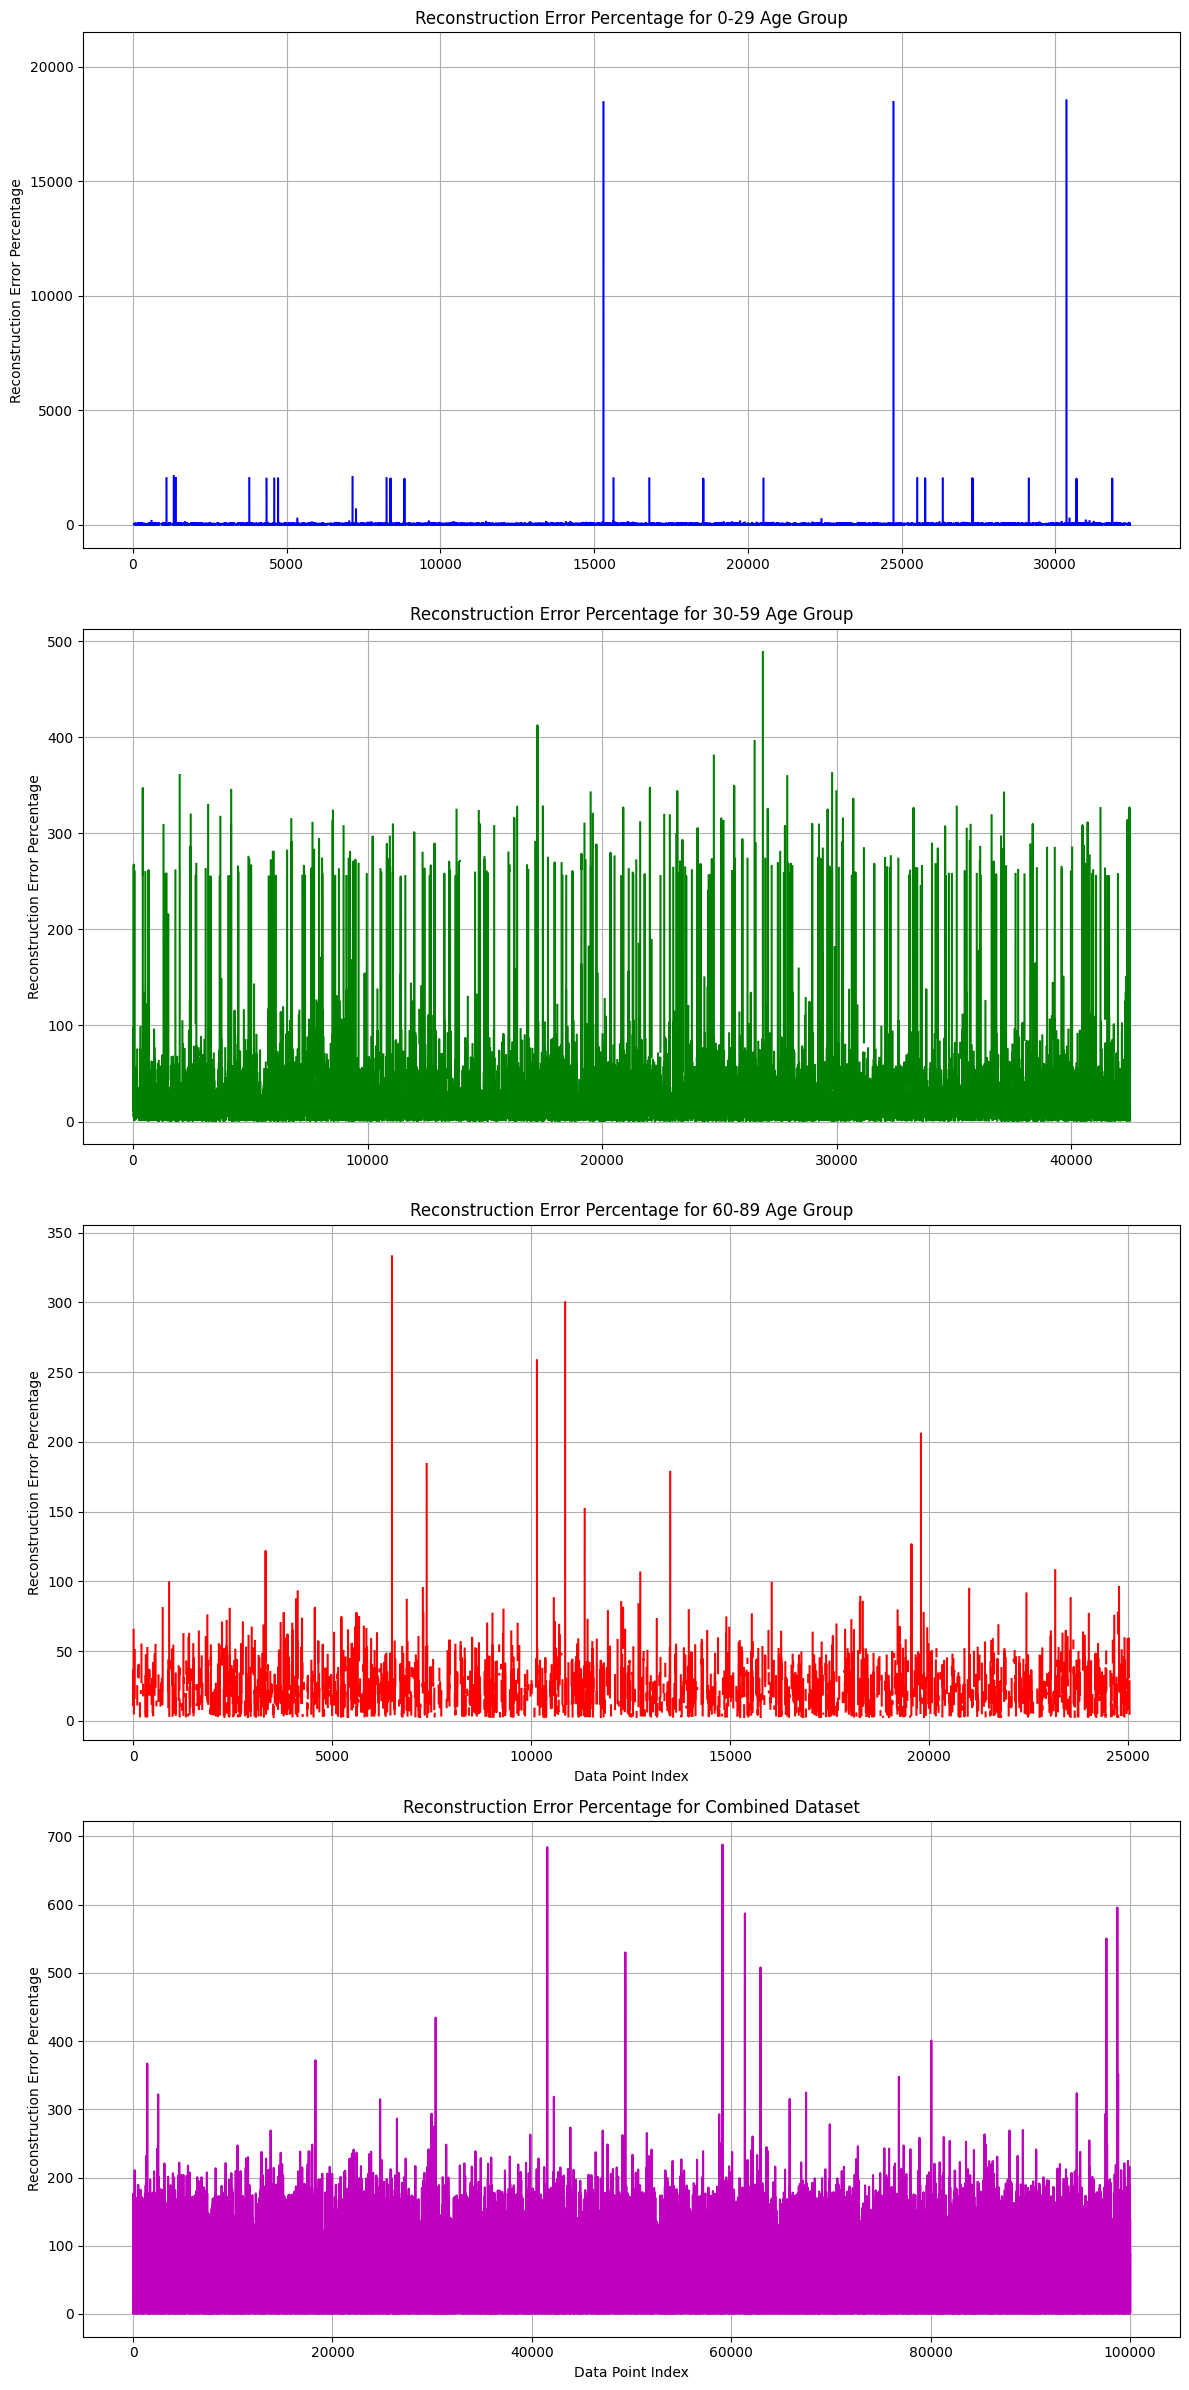

In [35]:
# Predict the reconstruction error for the 0-29 age group
reconstructed_test_0_29 = autoencoder.predict(x_test_0_29_scaled)
reconstruction_error_0_29 = np.mean(np.square(x_test_0_29_scaled - reconstructed_test_0_29), axis=1)
reconstruction_error_percentage_0_29 = reconstruction_error_0_29 * 100
mean_reconstruction_error_percentage_0_29 = np.mean(reconstruction_error_percentage_0_29)
print(f'Mean Reconstruction Error Percentage for 0-29 age group: {mean_reconstruction_error_percentage_0_29:.2f}%')

# Collect indices where error is over 300% for 0-29 age group
high_error_indices_0_29 = np.where(reconstruction_error_percentage_0_29 > 300)[0]

# Predict the reconstruction error for the 30-59 age group
reconstructed_test_30_59 = autoencoder.predict(x_test_30_59_scaled)
reconstruction_error_30_59 = np.mean(np.square(x_test_30_59_scaled - reconstructed_test_30_59), axis=1)
reconstruction_error_percentage_30_59 = reconstruction_error_30_59 * 100
mean_reconstruction_error_percentage_30_59 = np.mean(reconstruction_error_percentage_30_59)
print(f'Mean Reconstruction Error Percentage for 30-59 age group: {mean_reconstruction_error_percentage_30_59:.2f}%')

# Collect indices where error is over 300% for 30-59 age group
high_error_indices_30_59 = np.where(reconstruction_error_percentage_30_59 > 300)[0]

# Predict the reconstruction error for the 60-89 age group
reconstructed_test_60_89 = autoencoder.predict(x_test_60_89_scaled)
reconstruction_error_60_89 = np.mean(np.square(x_test_60_89_scaled - reconstructed_test_60_89), axis=1)
reconstruction_error_percentage_60_89 = reconstruction_error_60_89 * 100
mean_reconstruction_error_percentage_60_89 = np.mean(reconstruction_error_percentage_60_89)
print(f'Mean Reconstruction Error Percentage for 60-89 age group: {mean_reconstruction_error_percentage_60_89:.2f}%')

# Collect indices where error is over 300% for 60-89 age group
high_error_indices_60_89 = np.where(reconstruction_error_percentage_60_89 > 300)[0]

# Predict the reconstruction error for the combined dataset
reconstructed_data = autoencoder.predict(x_scaled)
reconstruction_error_combined = np.mean(np.square(x_scaled - reconstructed_data), axis=1)
reconstruction_error_percentage_combined = reconstruction_error_combined * 100
mean_reconstruction_error_percentage_combined = np.mean(reconstruction_error_percentage_combined)
print(f'Mean Reconstruction Error Percentage for Combined Dataset: {mean_reconstruction_error_percentage_combined:.2f}%')

# Collect indices where error is over 300% for combined dataset
high_error_indices_combined = np.where(reconstruction_error_percentage_combined > 300)[0]

# Plot the reconstruction error percentage for each data point as line graphs
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# Plot for 0-29 age group
axes[0].plot(reconstruction_error_percentage_0_29, linestyle='-', color='b')
axes[0].set_title('Reconstruction Error Percentage for 0-29 Age Group')
axes[0].set_ylabel('Reconstruction Error Percentage')
axes[0].grid(True)

# Plot for 30-59 age group
axes[1].plot(reconstruction_error_percentage_30_59, linestyle='-', color='g')
axes[1].set_title('Reconstruction Error Percentage for 30-59 Age Group')
axes[1].set_ylabel('Reconstruction Error Percentage')
axes[1].grid(True)

# Plot for 60-89 age group
axes[2].plot(reconstruction_error_percentage_60_89, linestyle='-', color='r')
axes[2].set_title('Reconstruction Error Percentage for 60-89 Age Group')
axes[2].set_xlabel('Data Point Index')
axes[2].set_ylabel('Reconstruction Error Percentage')
axes[2].grid(True)

# Plot for combined dataset
axes[3].plot(reconstruction_error_percentage_combined, linestyle='-', color='m')
axes[3].set_title('Reconstruction Error Percentage for Combined Dataset')
axes[3].set_xlabel('Data Point Index')
axes[3].set_ylabel('Reconstruction Error Percentage')
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [36]:
# Print indices of high error data points
print(f"Indices with high reconstruction error for 0-29 age group: {high_error_indices_0_29}")
print(f"Indices with high reconstruction error for 30-59 age group: {high_error_indices_30_59}")
print(f"Indices with high reconstruction error for 60-89 age group: {high_error_indices_60_89}")
print(f"Indices with high reconstruction error for combined dataset: {high_error_indices_combined}")

Indices with high reconstruction error for 0-29 age group: [  893  1091  1178  1328  1397  3762  3783  4062  4345  4441  4596  4719
  4941  6094  6246  6966  7143  7255  7300  8249  8378  8829  9189 11663
 15304 15630 16794 18372 18550 19688 19904 20508 21174 23891 24680 24736
 25509 25766 26340 27298 27322 29139 30363 30688 31022 31850]
Indices with high reconstruction error for 30-59 age group: [  418  1301  1891  1991  2184  2461  3204  3251  3375  3725  4181  4187
  5272  6749  7227  7652  7810  8105  8516  8523  8977 11083 11990 12264
 13794 14741 14771 15035 15052 15399 15789 16105 16175 16253 16377 17242
 17294 17476 18196 18491 19147 19207 19246 19364 19510 19606 20392 20899
 21621 21658 21671 22037 22648 22885 23203 24068 24708 24762 25077 25175
 25629 26304 26500 26520 26626 26852 27061 27794 27891 28954 29213 29245
 29612 29804 29986 30267 30419 30705 30841 31720 33274 33678 34621 35117
 35140 35543 35709 35713 36603 37117 37132 38191 38356 40046 40480 40698
 41245 41759 423